## 0. Load Data

In [1]:
dataname = 'yeast'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
df = pd.read_csv('../datasets/OD/%s/meta_data/%s.original.csv'%(dataname, dataname))
gt = pd.read_csv('../datasets/OD/%s/meta_data/%s.diff.csv'%(dataname, dataname))['ground.truth']
gt_idx = gt.index.values[gt == 'anomaly']

In [3]:
df.head()

,Y,M,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7
0,MIT,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,MIT,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,MIT,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,NUC,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,MIT,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


In [4]:
if dataname == "abalone":
    df.drop('F1', axis=1, inplace=True)

In [5]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [6]:
pf = Profiler(workers=2, tol=1e-5, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [7]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.007308006286621094] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'nan', 'NaN', 'None', '?', 'unknown', 'none'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "Y": "text",
    "M": "text",
    "V": "numeric",
    "V.1": "numeric",
    "V.2": "numeric",
    "V.3": "numeric",
    "V.4": "numeric",
    "V.5": "numeric",
    "V.6": "numeric",
    "V.7": "numeric"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'Y': ['equal'], 'M': ['equal'], 'V': ['equal'], 'V.1': ['equal'], 'V.2': ['equal'], 'V.3': ['equal'], 'V.4': ['equal'], 'V.5': ['equal'], 'V.6': ['equal'], 'V.7': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_tha

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [8]:

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [9]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [10]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[1.7129390239715576] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 32 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 32, and the bound is 0.00014964
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 10/10 [00:00<00:00, 185.17it/s]
INFO:profiler.data.transformer:Number of training samples: 59360
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[1.896432876586914] Create Training Data execution time: 0.18349385261535645



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [11]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[2.1023738384246826] Learn Structure start

INFO:profiler.learner:use threshold 0.0696
INFO:profiler.utility:[2.2485978603363037] Learn Structure execution time: 0.1462240219116211



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [12]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[2.8074350357055664] Get Dependencies start

INFO:profiler.utility:[2.850799798965454] Get Dependencies execution time: 0.043364763259887695



V.1,Y -> M (0.002444586762958698)
M -> V (0.09846137661028914)
M -> V.2 (0.11418997454801419)
M -> V.3 (0.10428477519685854)
V.1,Y,M -> V.5 (0.017626981238019757)
M -> V.6 (0.13108764364577266)
M -> V.7 (0.22917225524730456)
V.1,Y,M,V.3 -> V.4 (0.016571477505562624)


## 5. Visualization

In [13]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

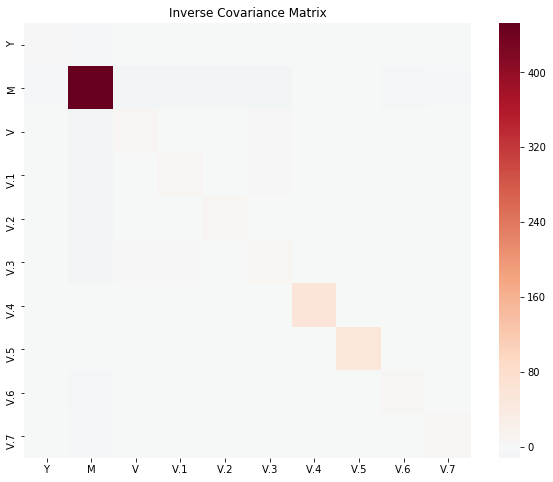

In [14]:
pf.session.visualize_inverse_covariance()

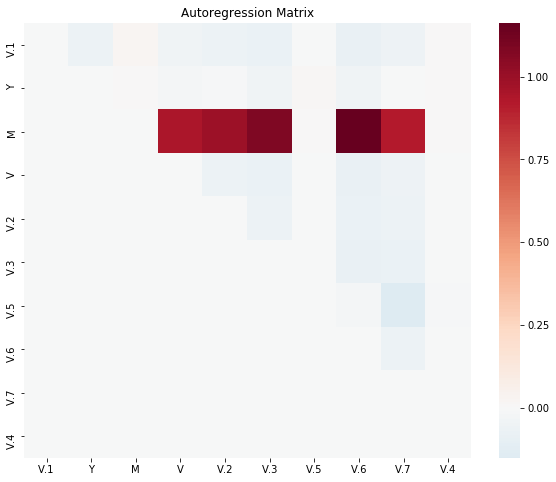

In [15]:
pf.session.visualize_autoregression()

In [16]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.007308,start: Load Data,0.000000
1,0.028745,end: Load Data,0.021437
2,1.712939,start: Create Training Data,0.000000
3,1.896433,end: Create Training Data,0.183494
4,2.102374,start: Learn Structure,0.000000
5,2.248598,end: Learn Structure,0.146224
6,2.807435,start: Get Dependencies,0.000000
7,2.850800,end: Get Dependencies,0.043365
8,2.850800,total_execution_time,0.394520


In [17]:
from profiler.app.od import *

In [18]:
detector = STDDetector(pf.session.ds.df, gt_idx)
detector.run_all(parent_sets)
detector.evaluate()

INFO:profiler.utility:[2.7894973754882812e-05] naive start

INFO:profiler.utility:[0.0013897418975830078] naive start



AttributeError: 'str' object has no attribute 'dtype'

In [ ]:
detector2 = ISFDetector(pf.session.ds.df, gt_idx)
detector2.run_all(parent_sets)
detector2.evaluate()